7. Time Series Prediction using LSTM: Use the given international airline passengers dataset problem. This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations. We can phrase the problem as a regression problem. That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month? Perform the following.


In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tqdm
# fix random seed for reproducibility
numpy.random.seed(7)


In [2]:
# load the dataset
df = pd.read_csv('../input/airline-passesngers/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [3]:
data = df.values
data = data.astype('float32')

a) Write a simple function to convert the single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

b) Pre-process the dataset: - Normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library. - Data split in train/tes

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [6]:
# reshape 
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

d) Train the network and perform hyper parameter tuning.

In [7]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(64, batch_input_shape=(batch_size, look_back, 1),stateful=True,return_sequences=True))
model.add(LSTM(64, stateful=True))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print (trainX.shape, trainY.shape)

2022-01-22 09:04:25.058406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:04:25.158912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:04:25.159785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 09:04:25.160960: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(83, 10, 1) (83,)


In [8]:

for i in tqdm.tqdm(range(20)):
    model.fit(trainX, trainY, epochs=3, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

  0%|          | 0/20 [00:00<?, ?it/s]2022-01-22 09:04:27.650797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 09:04:30.395758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


e) Evaluate the model.

In [9]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [10]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.00 RMSE
Test Score: 41.06 RMSE


f) Plot the original dataset along with train and test predictions to get an idea of how the trained model performs

In [11]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


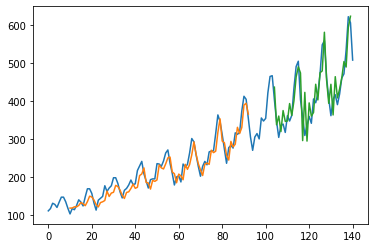

In [12]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()